In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Offer information (portfolio.json)

In [2]:
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


### The portfolio dataframe contains 10 unique offers and 6 fields:
* `id` (string) - offer id
* `offer_type` (string) - type of offer ie BOGO, discount, informational
* `difficulty` (int) - minimum required spend to complete an offer
* `reward` (int) - reward given for completing an offer
* `duration` (int) - time for offer to be open, in days
* `channels` (list of strings)

### Data cleaning to be performed:
* split `channels` into four binary columns, one for each channel type
* rename `id` to `offer_id` and encode each unique id with integers 

### Data preprocessing to be performed:
* engineer a new feature that captures the discount ratio of each offer

In [3]:
# split channels into dummy columns and drop the original column
for channel_name in ['web', 'email', 'mobile', 'social']:
    portfolio['channel_'+channel_name] = portfolio['channels'].apply(lambda x:int(channel_name in x))
portfolio.drop(['channels'], axis = 1, inplace = True)

# rename and encode column id; also save the lut
def encode_column(df, col_name, encoded_col_name):
    vals = df[col_name].unique()
    encoded_vals = [int(i) for i in range(len(vals))]
    lut_inverse = dict(zip(vals, encoded_vals))
    lut = dict(zip(encoded_vals, vals))
    df[encoded_col_name] = df[col_name].apply(lambda x:lut_inverse[x])
    return lut, lut_inverse
offer_id_lut, offer_id_lut_inverse = encode_column(portfolio, 'id', 'offer_id')
portfolio.drop(['id'], axis = 1, inplace = True)

# engineer a new feature: discount_ratio. note that "bogo" and "discount" need to be treated differently
def discount_ratio(row):
    if row['offer_type'] == 'bogo':
        val = 0.5
    elif row['offer_type'] == 'discount':
        val = row['reward']/row['difficulty']
    else:
        val = 0
    return val
portfolio['discount_ratio'] = portfolio.apply(discount_ratio, axis = 1)

# reorder columns
portfolio = portfolio[['offer_id', 'reward', 'difficulty', 'duration', 'offer_type', 'channel_web',\
       'channel_email', 'channel_mobile', 'channel_social', 'discount_ratio']]

In [4]:
# cleaned df
portfolio

,offer_id,reward,difficulty,duration,offer_type,channel_web,channel_email,channel_mobile,channel_social,discount_ratio
0,0,10,10,7,bogo,0,1,1,1,0.500000
1,1,10,10,5,bogo,1,1,1,1,0.500000
2,2,0,0,4,informational,1,1,1,0,0.000000
3,3,5,5,7,bogo,1,1,1,0,0.500000
4,4,5,20,10,discount,1,1,0,0,0.250000
5,5,3,7,7,discount,1,1,1,1,0.428571
6,6,2,10,10,discount,1,1,1,1,0.200000
7,7,0,0,3,informational,0,1,1,1,0.000000
8,8,5,5,5,bogo,1,1,1,1,0.500000
9,9,2,10,7,discount,1,1,1,0,0.200000


## 2. Customer information (profile.json)

In [5]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


### The profile dataframe contains 17000 unique customers and 5 fields:
* `age` (int) - age of the customer 
* `became_member_on` (int) - date when customer created an app account
* `gender` (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* `id` (str) - customer id
* `income` (float) - customer's income

### Data cleaning to be performed:
* replace all the None in `gender` with NaN
* replace all 118 in `age` with NaN
* rename `id` to `customer_id` and encode each unique id with integers
* group `became_member_on` by year

In [6]:
# replace meaningless cells with NaN
profile['gender'] = profile['gender'].fillna(value = np.nan)
profile['age'] = profile['age'].replace(118, np.nan)

# encode and rename column "id"
customer_id_lut, customer_id_lut_inverse = encode_column(profile, 'id', 'customer_id')
profile.drop(['id'], axis=1, inplace=True)

# group became_member_on by year
profile['became_member_on'] = (profile['became_member_on']//10000)

# reorder columns
profile = profile[['customer_id', 'gender', 'age', 'became_member_on', 'income']]

In [7]:
# cleaned df
profile.head()

,customer_id,gender,age,became_member_on,income
0,0,NaN,NaN,2017,NaN
1,1,F,55.0,2017,112000.0
2,2,NaN,NaN,2018,NaN
3,3,F,75.0,2017,100000.0
4,4,NaN,NaN,2017,NaN


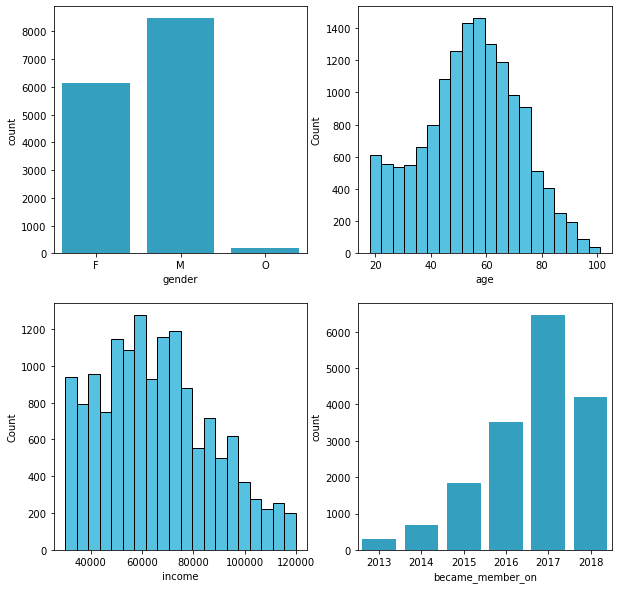

In [36]:
# plot distributions of cleaned data
fig, axs = plt.subplots(2, 2, figsize = (10,10))
sns.countplot(data = profile, x = 'gender', color="#1dacd6", ax = axs[0, 0])
sns.histplot(profile.age, bins = 20, color="#1dacd6", ax = axs[0, 1])
sns.histplot(profile.income, bins = 20, color="#1dacd6", ax = axs[1, 0])
sns.countplot(data = profile, x = 'became_member_on', color="#1dacd6", ax = axs[1, 1]);

## 3. Transaction and offer redemption information (transcript.json)

In [9]:
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


### The transcript dataframe contains 306534 records and 4 fields:
* `event` (str) - record description, including transaction, offer received, offer viewed, and offer completed
* `person` (str) - customer id
* `time` (int) - time in hours since start of test. The data begins at time t = 0
* `value` - (dict of strings) - either an offer id or transaction amount depending on the record

### Data cleaning to be performed:
* replace `person` with `customer_id`
* split `value` into two new columns: `offer_id` and `amount`

### Data preprocessing to be performed:
* engineer a new feature named `rank`, which is critical to offer event matching (matching an offer completion to its corresponding offer receiption and view), because a customer can receive and complete an offer multiple times. 

In [10]:
# replace person with customer_id
transcript['customer_id'] = transcript['person'].apply(lambda x:customer_id_lut_inverse[x])
transcript.drop(['person'], axis = 1, inplace=True)

# split value into two new columns: offer_id and amount
def extract_offer_id(x):
    if 'offer id' in x:
        return offer_id_lut_inverse[x['offer id']]
    if 'offer_id' in x:
        return offer_id_lut_inverse[x['offer_id']]
    return np.nan

transcript['offer_id'] = transcript['value'].apply(extract_offer_id)
transcript['amount'] = transcript['value'].apply(lambda x:x.get('amount', np.nan))
transcript.drop(['value'], axis = 1, inplace=True)

# rank each event according to time
transcript['rank'] = transcript.sort_values('time').groupby(['customer_id', 'offer_id', 'event'])['time'].cumcount()+1

In [11]:
# cleaned df
transcript.head()

,event,time,customer_id,offer_id,amount,rank
0,offer received,0,3,3.0,NaN,1
1,offer received,0,4,4.0,NaN,1
2,offer received,0,5,9.0,NaN,1
3,offer received,0,6,6.0,NaN,1
4,offer received,0,7,1.0,NaN,1


### Further discussion on `rank`
Let's use the example below to see how `rank` helps distinguish offer cycles and why it is critical to further analyses. 

Customer #15 received offer #5 three times, viewed it two times, and completed it three times. Although all events shared the same `offer_id`, `rank` helps separate them into three cycles. `rank` also helps identify that **the last cycle of offer was not viewed before completed**. Therefore **further analyses on offer reponse should exclude the last offer** because it did not influence the customer's behavior.

In [12]:
# customer #15, offer #5
transcript[(transcript['customer_id']==15) & (transcript['offer_id']==5)]\
        .drop(['amount','customer_id'],axis=1).sort_values(['offer_id','rank'])

,event,time,offer_id,rank
110837,offer received,336,5.0,1
123542,offer viewed,336,5.0,1
143576,offer completed,384,5.0,1
150605,offer received,408,5.0,2
174357,offer viewed,426,5.0,2
174359,offer completed,426,5.0,2
201579,offer received,504,5.0,3
230415,offer completed,534,5.0,3


### Split transcript dataframe for further analyses
* The first dataframe `transactions` contains all transaction information
* The second dataframe `offers` contains all offer events 
    * Each row contains matching receiption/view/completion events with the same `customer_id`, `offer_id`, and `rank`
    * A new integer column `response` engineered to mark a customer's response to an offer
        * 1: offer received, not viewed or redeemed
        * 2: offer received and viewed, not redeemed
        * 3: offer received, viewed, and redeemed
        * 0: offer received and redeemed, but redeemed without being viewed. Note that this scenario was given ***the lowest rating because I want to discourage this type of offer being sent to customers*** - the customers will spend the money anyway, hence no offer needed.

In [26]:
# the first dataframe contains transaction information
transactions = transcript[transcript['offer_id'].isna()].drop(['event','rank','offer_id'], axis=1)
transactions = transactions[['customer_id','time','amount']].sort_values(by = ['customer_id','time','amount'])
transactions.head()

,customer_id,time,amount
135224,0,360,0.35
167626,0,414,0.74
182544,0,444,1.89
218392,0,510,5.04
230411,0,534,0.38


In [27]:
# The second dataframe contains offer events information

# df for each offer event type
offers_received = transcript[transcript['event']=='offer received'].drop('amount', axis=1)
offers_viewed = transcript[transcript['event']=='offer viewed'].drop('amount', axis=1)
offers_completed = transcript[transcript['event']=='offer completed'].drop('amount', axis=1)

# merged offer events with matching receiption/view/completion 
offers = pd.merge(pd.merge(offers_received, offers_viewed, how = 'left', \
                            on = ['customer_id','offer_id','rank']), \
                    offers_completed, how = 'left', on = ['customer_id','offer_id','rank'])
offers = offers.drop(['event_x','event_y','event'], axis = 1) \
                .rename(columns = {'time_x':'time_received', 'time_y':'time_viewed', 'time':'time_completed'})

# convert offer_id to int
offers['offer_id'] = offers['offer_id'].astype(int)

# engineer a new column "viewed"
# offers['viewed'] = (~offers['time_viewed'].isna()).astype(int)

# engineer a new column "responded"
# offers['responded'] = (offers['time_viewed'] <= offers['time_completed']).astype(int)


In [28]:
# engineer a new column "response"
def conditions(df):
    if np.isnan(df['time_viewed']) and np.isnan(df['time_completed']):
        return 1
    if np.isnan(df['time_completed']):
        return 2
    if df['time_viewed'] <= df['time_completed']:
        return 3
    return 0

offers['response'] = offers.apply(conditions, axis = 1)


In [29]:
# reorder columns and rows
offers = offers[['customer_id','offer_id','rank','time_received','time_viewed','time_completed','response']]\
                .sort_values(by = ['customer_id','offer_id','rank'])
offers.head()

,customer_id,offer_id,rank,time_received,time_viewed,time_completed,response
25319,0,4,1,336,348.0,NaN,2
50808,0,5,1,504,504.0,552.0,3
38030,0,6,1,408,408.0,552.0,3
63512,0,6,2,576,582.0,NaN,2
12650,0,9,1,168,216.0,NaN,2


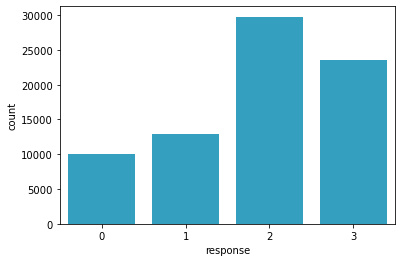

In [37]:
# plot of customer response to offers
sns.countplot(data = offers, x = 'response', color = '#1dacd6');

## 4. Save processed dataframes as a pickle file

In [31]:
with open("data/processed_data.pickle", "wb") as f:
    pickle.dump([portfolio, profile, transactions, offers], f)